In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

/home/aphuc/ai/workspace/xdoc/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# (Assuming data loading and model training are done as before)
# Load and preprocess data (recap)
data = pd.read_csv("diabetes.csv")
X = data.drop(columns=["Class"])
y = data["Class"]
X["Gender"] = LabelEncoder().fit_transform(X["Gender"])
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:

# Train XGBoost model (recap)
xgb_model = xgb.XGBClassifier(
    objective="multi:softprob", num_class=3, eval_metric="mlogloss", 
    use_label_encoder=False, random_state=42
)
xgb_model.fit(X_train, y_train)

/home/aphuc/ai/workspace/xdoc/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [09:04:42] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, num_class=3, ...)

In [4]:
# Test model
y_pred = xgb_model.predict(X_test)
accuracy = (y_pred == y_test).mean()
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [ ]:
# Compute SHAP values
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test)
print(f"SHAP values shape: {shap_values.shape}")  # Confirm (n_samples, n_features, 3)

SHAP values shape: (53, 11, 3)


In [6]:
# Select single patient
single_patient = X_test.iloc[0]

# Predict
predicted_class = xgb_model.predict(single_patient.values.reshape(1, -1))[0]
probabilities = xgb_model.predict_proba(single_patient.values.reshape(1, -1))[0]
class_labels = le.classes_  # ['Diabetic', 'Non-Diabetic', 'Pre-Diabetic']
print(f"Predicted Class: {class_labels[predicted_class]}")
print(f"Probabilities: {dict(zip(class_labels, probabilities))}")

Predicted Class: 0
Probabilities: {np.int64(0): np.float32(0.998572), np.int64(1): np.float32(0.0011199351), np.int64(2): np.float32(0.0003081029)}


In [ ]:
# Extract SHAP values for the single patient
# shap_values[0, :, :] gives (n_features, 3) for the first patient
shap_values_single = shap_values[0, :, :]  # Shape: (n_features, 3)

# Print SHAP values for the predicted class
predicted_class_idx = predicted_class  # e.g., 0 for Diabetic
print(f"\nSHAP Values for {class_labels[predicted_class_idx]}:")
for feature, shap_val in zip(X.columns, shap_values_single[:, predicted_class_idx]):
    print(f"{feature}: {shap_val:.4f}")


SHAP Values for 0:
Gender: 0.0000
AGE: 0.0547
Urea: 0.0000
Cr: 0.0439
HbA1c: 2.5267
Chol: 0.3846
TG: 0.3109
HDL: 0.1381
LDL: 0.0000
VLDL: 0.1329
BMI: 0.4406


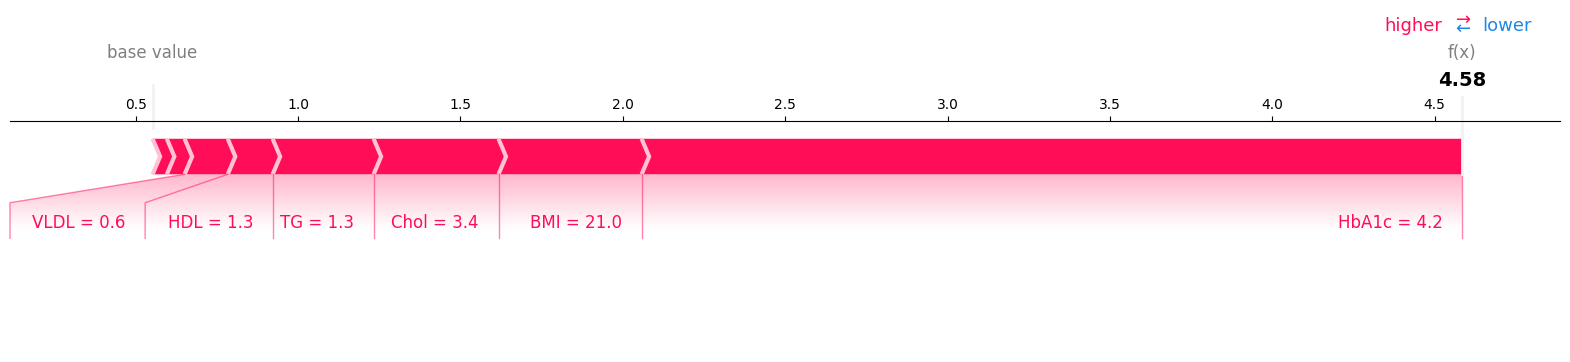


SHAP Contributions for 0:
Gender: 0.0000
AGE: 0.0547
Urea: 0.0000
Cr: 0.0439
HbA1c: 2.5267
Chol: 0.3846
TG: 0.3109
HDL: 0.1381
LDL: 0.0000
VLDL: 0.1329
BMI: 0.4406

SHAP Contributions for 1:
Gender: 0.0000
AGE: 0.3370
Urea: 0.0549
Cr: 0.0000
HbA1c: -1.6064
Chol: -0.0789
TG: -0.1290
HDL: -0.0235
LDL: 0.1526
VLDL: -0.1238
BMI: -0.1235

SHAP Contributions for 2:
Gender: 0.0685
AGE: -0.4288
Urea: -0.2033
Cr: -0.1646
HbA1c: -2.6824
Chol: -0.5046
TG: -0.0439
HDL: -0.0273
LDL: -0.1629
VLDL: -0.0345
BMI: -0.7128


In [8]:

# Force plot for the predicted class
# Note: Convert to list for feature names compatibility
shap.force_plot(
    explainer.expected_value[predicted_class_idx],
    shap_values_single[:, predicted_class_idx],
    single_patient,
    feature_names=X.columns.tolist(),
    matplotlib=True
)
plt.show()

# Optional: Compare SHAP values across all classes
for i, class_name in enumerate(class_labels):
    print(f"\nSHAP Contributions for {class_name}:")
    for feature, shap_val in zip(X.columns, shap_values_single[:, i]):
        print(f"{feature}: {shap_val:.4f}")

ValueError: Could not find feature named: Glucose

In [8]:
import os
from google import genai
from google.genai import types
from dotenv import load_dotenv
load_dotenv("key.env")

def generate(prompt):
    key = os.environ.get("GEMINI_API_KEY")
    if key is None:
        raise ValueError("Please set the GEMINI_API_KEY environment variable")
    client = genai.Client(
        api_key=os.environ.get("GEMINI_API_KEY"),
    )

    model = "gemini-2.0-flash"
    contents = [
        types.Content(
            role="user",
            parts=[
                types.Part.from_text(text=prompt),
            ],
        ),
    ]
    generate_content_config = types.GenerateContentConfig(
        temperature=1,
        top_p=0.95,
        top_k=40,
        max_output_tokens=8192,
        response_mime_type="text/plain",
    )

    for chunk in client.models.generate_content_stream(
        model=model,
        contents=contents,
        config=generate_content_config,
    ):
        print(chunk.text, end="")

In [9]:
import numpy as np
import pandas as pd

# Assume xgb_model is your trained XGBoost model, X_test is your test data
# and class_labels = ["Non-Diabetic", "Pre-Diabetic", "Diabetic"]

# Select a single patient
single_patient = X_test.iloc[0]
predicted_class = xgb_model.predict(single_patient.values.reshape(1, -1))[0]
probabilities = xgb_model.predict_proba(single_patient.values.reshape(1, -1))[0]

# Calculate SHAP values (assuming explainer is already created)
shap_values = explainer.shap_values(single_patient.values.reshape(1, -1))
shap_vals_pred = shap_values[0, :, predicted_class]  # SHAP for predicted class

# Get top 3 features by SHAP value
top_indices = np.argsort(np.abs(shap_vals_pred))[-3:][::-1]
top_features = X_test.columns[top_indices]
top_shap = shap_vals_pred[top_indices]
top_values = single_patient[top_indices]

# Create prompt
prompt = f"""
You are a medical assistant AI. Based on the following data, explain the diabetes prediction in simple terms for a patient.

Prediction: The model predicts a {probabilities[predicted_class]*100:.0f}% chance of being {class_labels[predicted_class]}.

Top contributing factors:
- Feature: {top_features[0]}, Value: {top_values[0]}, SHAP contribution: {top_shap[0]:.2f}
- Feature: {top_features[1]}, Value: {top_values[1]}, SHAP contribution: {top_shap[1]:.2f}
- Feature: {top_features[2]}, Value: {top_values[2]}, SHAP contribution: {top_shap[2]:.2f}

Clinical context:
- HbA1c: Normal <5.7%, Pre-Diabetes 5.7-6.4%, Diabetes ≥6.5%
- Fasting Blood Sugar: Normal <100 mg/dL, Pre-Diabetes 100-125 mg/dL, Diabetes ≥126 mg/dL
- BMI: Normal 18.5-24.9, Overweight 25-29.9, Obese ≥30

Please provide a clear, concise explanation suitable for a non-technical audience.
"""

# Generate explanation
generate(prompt)

/tmp/ipykernel_15982/2987299492.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  top_values = single_patient[top_indices]
/tmp/ipykernel_15982/2987299492.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  - Feature: {top_features[0]}, Value: {top_values[0]}, SHAP contribution: {top_shap[0]:.2f}
/tmp/ipykernel_15982/2987299492.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  - Feature: {top_features[1]}, Value: {top_values[

Okay, based on the information we have, the prediction model is saying there's a 100% chance that you *don't* have diabetes. So, that's good news!

The main reasons the model is confident in this prediction are:

*   **Your HbA1c level is 4.2.** HbA1c is a measure of your average blood sugar over the past 2-3 months.  A level below 5.7% is considered normal, and yours is well within the normal range. This is the biggest factor in the prediction.
*   **Your BMI is 21.0.** Your Body Mass Index (BMI) is a measure of body fat based on your height and weight. A BMI between 18.5 and 24.9 is considered normal, so yours is healthy.
*   **Your Cholesterol is 3.4.** A cholesterol level of 3.4 is good and means you are not at risk for issues related to high cholestrol.

Basically, your blood sugar levels and weight are all within healthy ranges, leading the model to believe you are not diabetic.


In [ ]:
xgb_model.save_model("xgb_model.json")

['xgboost_diabetes_model.pkl']